In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

## Load and split data

In [2]:
import pickle
with open('../DATA/super_res/super_res_array.pickle','rb') as f:
    img_array = pickle.load(f)

In [3]:
from sklearn.model_selection import train_test_split 

all_images = np.array(img_array)

#Split test and train data. all_images will be our output images
train_x, test_x = train_test_split(all_images, random_state = 32, test_size=0.2)

## Pixalete the images 

In [4]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 20):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
    # scale back to original size
    width = int(small_image.shape[1] * 100 / scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)
    low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
    return low_res_image

In [5]:
train_x_px = []
for i in range(train_x.shape[0]):
    temp = pixalate_image(train_x[i,:,:,:])
    train_x_px.append(temp)
    
train_x_px = np.array(train_x_px)   #Distorted images
# get low resolution images for the validation set
test_x_px = []
for i in range(test_x.shape[0]):
    temp = pixalate_image(test_x[i,:,:,:])
    test_x_px.append(temp)
    
test_x_px = np.array(test_x_px)     #Distorted images

In [6]:
train_x_px.shape

(10586, 160, 160, 3)

## Predictions

### Prediction ResNet18

In [7]:
#load the model
model = keras.models.load_model('final_models/resnet18AE.h5')

#predict the images
preds_r18 = model.predict(test_x_px)

83/83 [==============================] - 11s 61ms/step


### Prediction ResNet34

In [8]:
#load the model
model = keras.models.load_model('final_models/resnet34AE_lr0005.h5')

#predict the images
preds_r34 = model.predict(test_x_px)

83/83 [==============================] - 7s 77ms/step


### Prediction ResNet50

In [9]:
#load the model
model = keras.models.load_model('final_models/resnet50AE_lr0003.h5')

#predict the images
preds_r50 = model.predict(test_x_px)

83/83 [==============================] - 15s 152ms/step


### Prediction vgg16

In [10]:
#load the model
model = keras.models.load_model('final_models/vgg16AE_lr001.h5')

#predict the images
preds_v16 = model.predict(test_x_px)

83/83 [==============================] - 18s 148ms/step


### Prediction VGG19

In [11]:
#load the model
model = keras.models.load_model('final_models/vgg19AE_lr0001.h5')

#predict the images
preds_v19 = model.predict(test_x_px)

83/83 [==============================] - 9s 113ms/step


## Metrics

In [12]:
# ssim from skimage
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, preds):
    ssim_val = []
    for i in range(original.shape[0]):
        ssim_val.append(ssim(original[i], preds[i], multichannel = True, data_range=1.0, channel_axis=2))
    return ssim_val

In [13]:
def get_metrics_eval(test_x_image, preds, model_name):
    ssim_val = calculate_ssim(test_x_image, preds)
    mse = tf.keras.losses.mean_squared_error(tf.convert_to_tensor(test_x_image), tf.convert_to_tensor(preds))
    mae = tf.keras.losses.mean_absolute_error(tf.convert_to_tensor(test_x_image), tf.convert_to_tensor(preds))
    psnr = tf.image.psnr(tf.convert_to_tensor(test_x_image), tf.convert_to_tensor(preds), 1.0)

    mean_ssim = np.mean(ssim_val)
    mean_mse = tf.reduce_mean(mse).numpy()
    mean_mae = tf.reduce_mean(mae).numpy()
    mean_psnr = tf.reduce_mean(psnr).numpy()

    std_ssim = np.std(ssim_val)
    std_mse = tf.math.reduce_std(mse).numpy()
    std_mae = tf.math.reduce_std(mae).numpy()
    std_psnr = tf.math.reduce_std(psnr).numpy()

    output = f"Model: {model_name}\t"
    output += f"SSIM: {mean_ssim:.4f}\u00B1{std_ssim:.4f}\t"
    output += f"MSE: {mean_mse:.4f}\u00B1{std_mse:.4f}\t"
    output += f"MAE: {mean_mae:.4f}\u00B1{std_mae:.4f}\t"
    output += f"PSNR: {mean_psnr:.4f}\u00B1{std_psnr:.4f}\n"
    # 4 decimals
    print(output)

In [14]:
get_metrics_eval(test_x, preds_r18, "ResNetAE-18")
get_metrics_eval(test_x, preds_r34, "ResNetAE-34")
get_metrics_eval(test_x, preds_r50, "ResNetAE-50")
get_metrics_eval(test_x, preds_v16, "VGGAE-16")
get_metrics_eval(test_x, preds_v19, "VGGAE-19")

Model: ResNetAE-18	SSIM: 0.7222±0.0666	MSE: 0.0043±0.0141	MAE: 0.0448±0.0443	PSNR: 23.9911±1.6034

Model: ResNetAE-34	SSIM: 0.7188±0.0676	MSE: 0.0039±0.0126	MAE: 0.0418±0.0420	PSNR: 24.4042±1.6419

Model: ResNetAE-50	SSIM: 0.7106±0.0627	MSE: 0.0042±0.0134	MAE: 0.0424±0.0445	PSNR: 24.1833±1.7430

Model: VGGAE-16	SSIM: 0.6711±0.0733	MSE: 0.0059±0.0170	MAE: 0.0490±0.0538	PSNR: 22.7282±1.8825

Model: VGGAE-19	SSIM: 0.7059±0.0692	MSE: 0.0048±0.0147	MAE: 0.0438±0.0493	PSNR: 23.6296±1.9434



In [15]:
def get_metric_image(original, predicted):
    ssim_value = ssim(original, predicted, multichannel = True, data_range=1.0, channel_axis=2)
    psnr = tf.image.psnr(tf.convert_to_tensor(original), tf.convert_to_tensor(predicted), 1.0).numpy()

    return round(ssim_value, 4), round(psnr,4)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def display(indices, language='en'):
    rows = len(indices)
    columns = 7

    fig, axs = plt.subplots(rows, columns, figsize=(20, 15))
    
    for i, index in enumerate(indices):
        original = test_x[index]
        low_res = test_x_px[index]
        resnet18 = preds_r18[index]
        resnet34 = preds_r34[index]
        resnet50 = preds_r50[index]
        vgg16 = preds_v16[index]
        vgg19 = preds_v19[index]
        
        axs[i, 0].imshow(original)
        axs[i, 0].axis('off')
        # axs[i, 0].set_title('Original')

        axs[i, 1].imshow(low_res)
        axs[i, 1].axis('off')
        ssim_val, psnr_val = get_metric_image(original, low_res)
        axs[i, 1].text(0.5, -0.1, f"SSIM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 1].transAxes)

        axs[i, 2].imshow(np.clip(resnet18, 0, 1))
        axs[i, 2].axis('off')
        ssim_val, psnr_val = get_metric_image(original, resnet18)
        axs[i, 2].text(0.5, -0.1, f"SSIM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 2].transAxes)

        axs[i, 3].imshow(resnet34)
        axs[i, 3].axis('off')
        ssim_val, psnr_val = get_metric_image(original, resnet34)
        axs[i, 3].text(0.5, -0.1, f"SSIM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 3].transAxes)

        axs[i, 4].imshow(resnet50)
        axs[i, 4].axis('off')
        ssim_val, psnr_val = get_metric_image(original, resnet50)
        axs[i, 4].text(0.5, -0.1, f"SISM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 4].transAxes)

        axs[i, 5].imshow(vgg16)
        axs[i, 5].axis('off')
        ssim_val, psnr_val = get_metric_image(original, vgg16)
        axs[i, 5].text(0.5, -0.1, f"SISM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 5].transAxes)

        axs[i, 6].imshow(vgg19)
        axs[i, 6].axis('off')
        ssim_val, psnr_val = get_metric_image(original, vgg19)
        axs[i, 6].text(0.5, -0.1, f"SISM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 6].transAxes)
        
    # Añadir texto centrado debajo de cada columna
    if language == 'en':
        column_titles = [
            "Original",
            "Low Resolution",
            "ResNetAE-18",
            "ResNetAE-34",
            "ResNetAE-50",
            "VGGAE-16",
            "VGGAE-19"
        ]
    elif language == 'es':
        column_titles = [
            "Original",
            "Baja Resolución",
            "ResNetAE-18",
            "ResNetAE-34",
            "ResNetAE-50",
            "VGGAE-16",
            "VGGAE-19"
        ]

    for col in range(columns):
        # Obtener la posición media de la columna en coordenadas normalizadas
        mid = axs[0, col].get_position().x0 + axs[0, col].get_position().width / 2
        fig.text(
            mid,      # posición x centrada para cada columna
            0.9,      # posición y ajustada fuera de las imágenes
            column_titles[col], 
            ha='center', va='center', fontsize=20
        )

    plt.subplots_adjust(hspace=0.4)
    plt.show()


In [17]:
# list of 5 random indices
indices = list(np.random.choice(test_x.shape[0], 5))
indices 

[2176, 1205, 1861, 1000, 305]

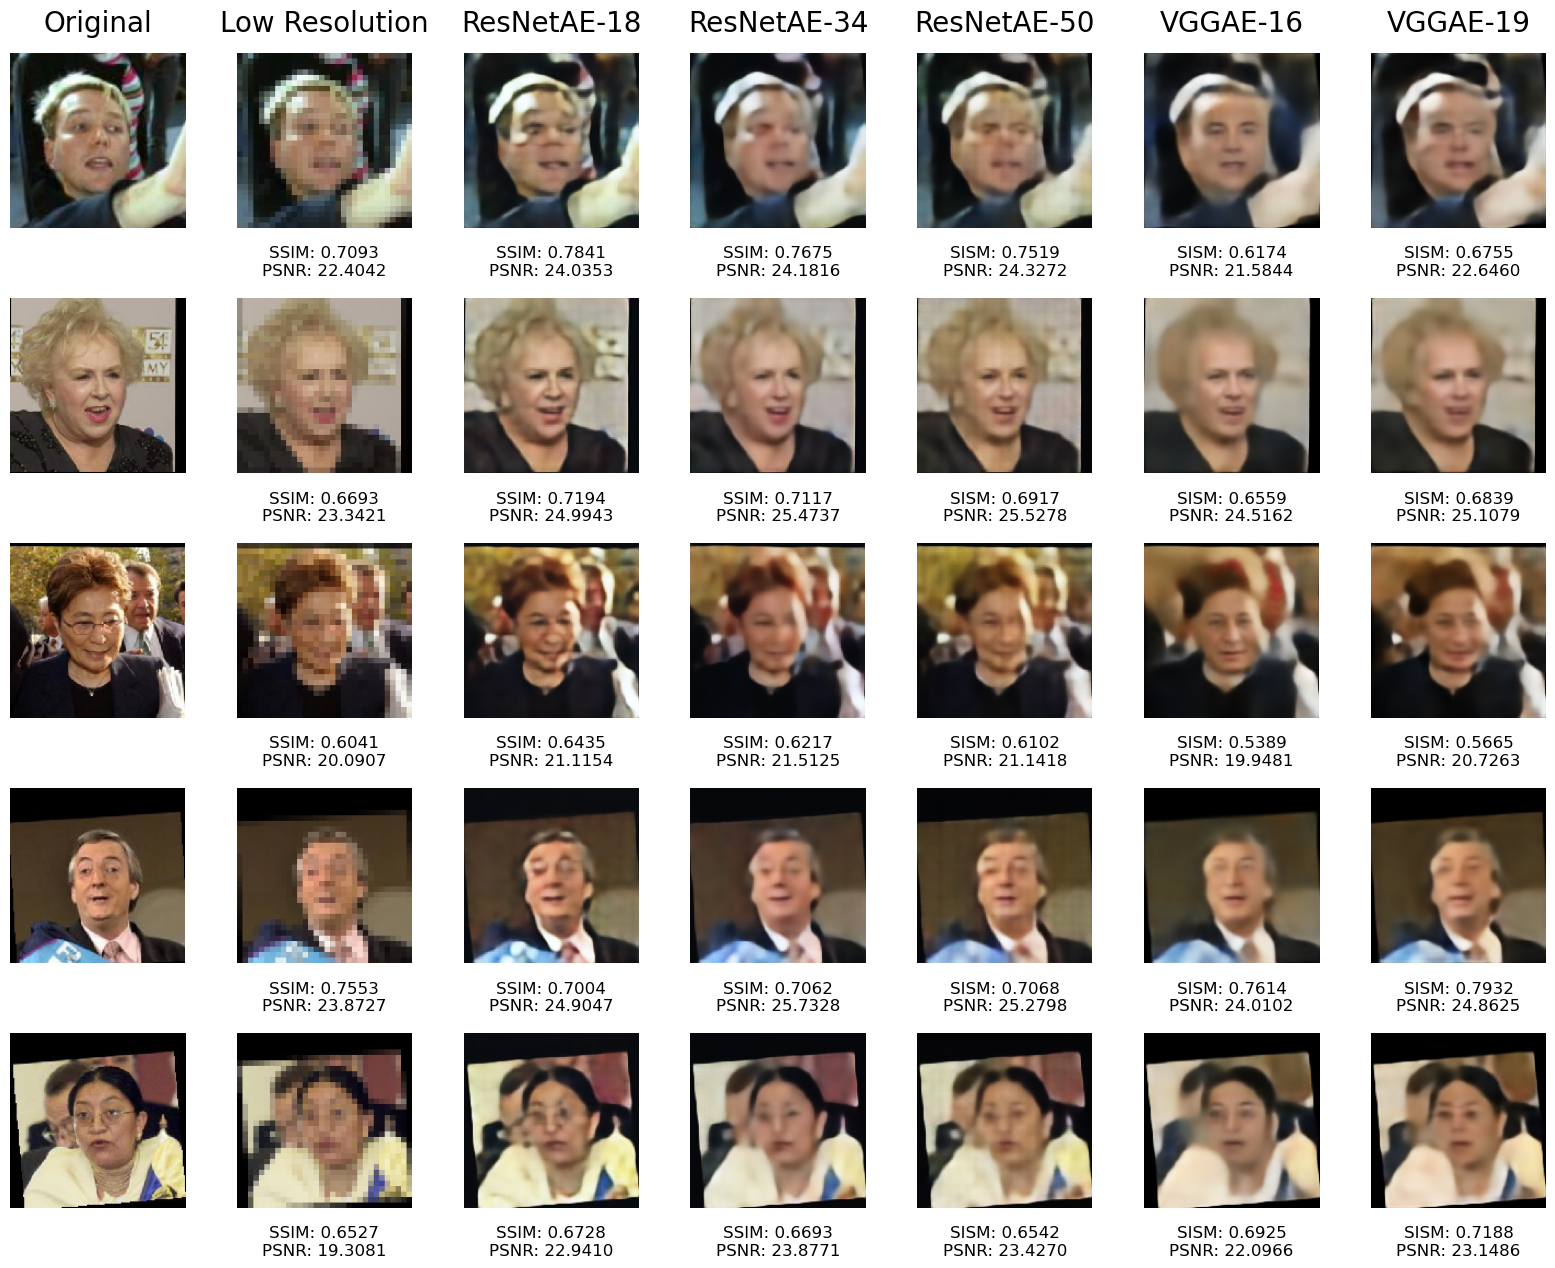

In [18]:
display(indices)

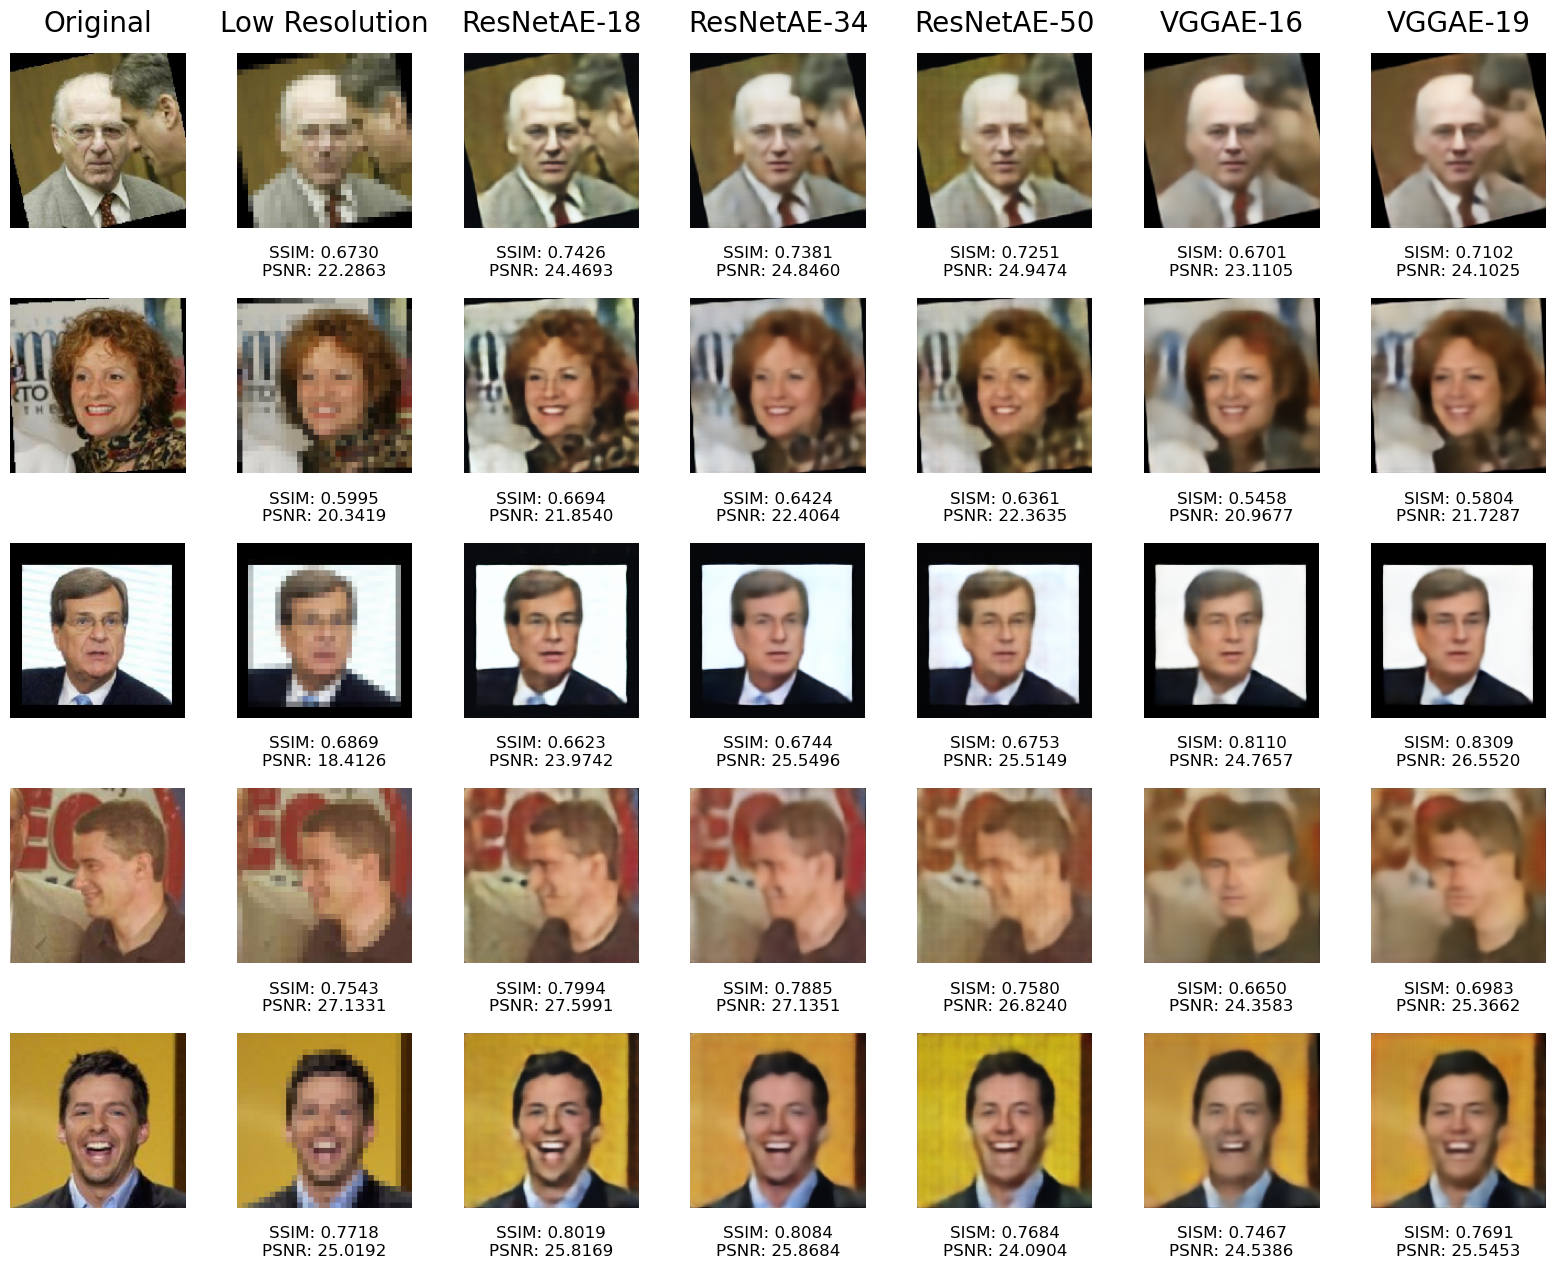

In [19]:
display([762,2235,359,2629,2112])

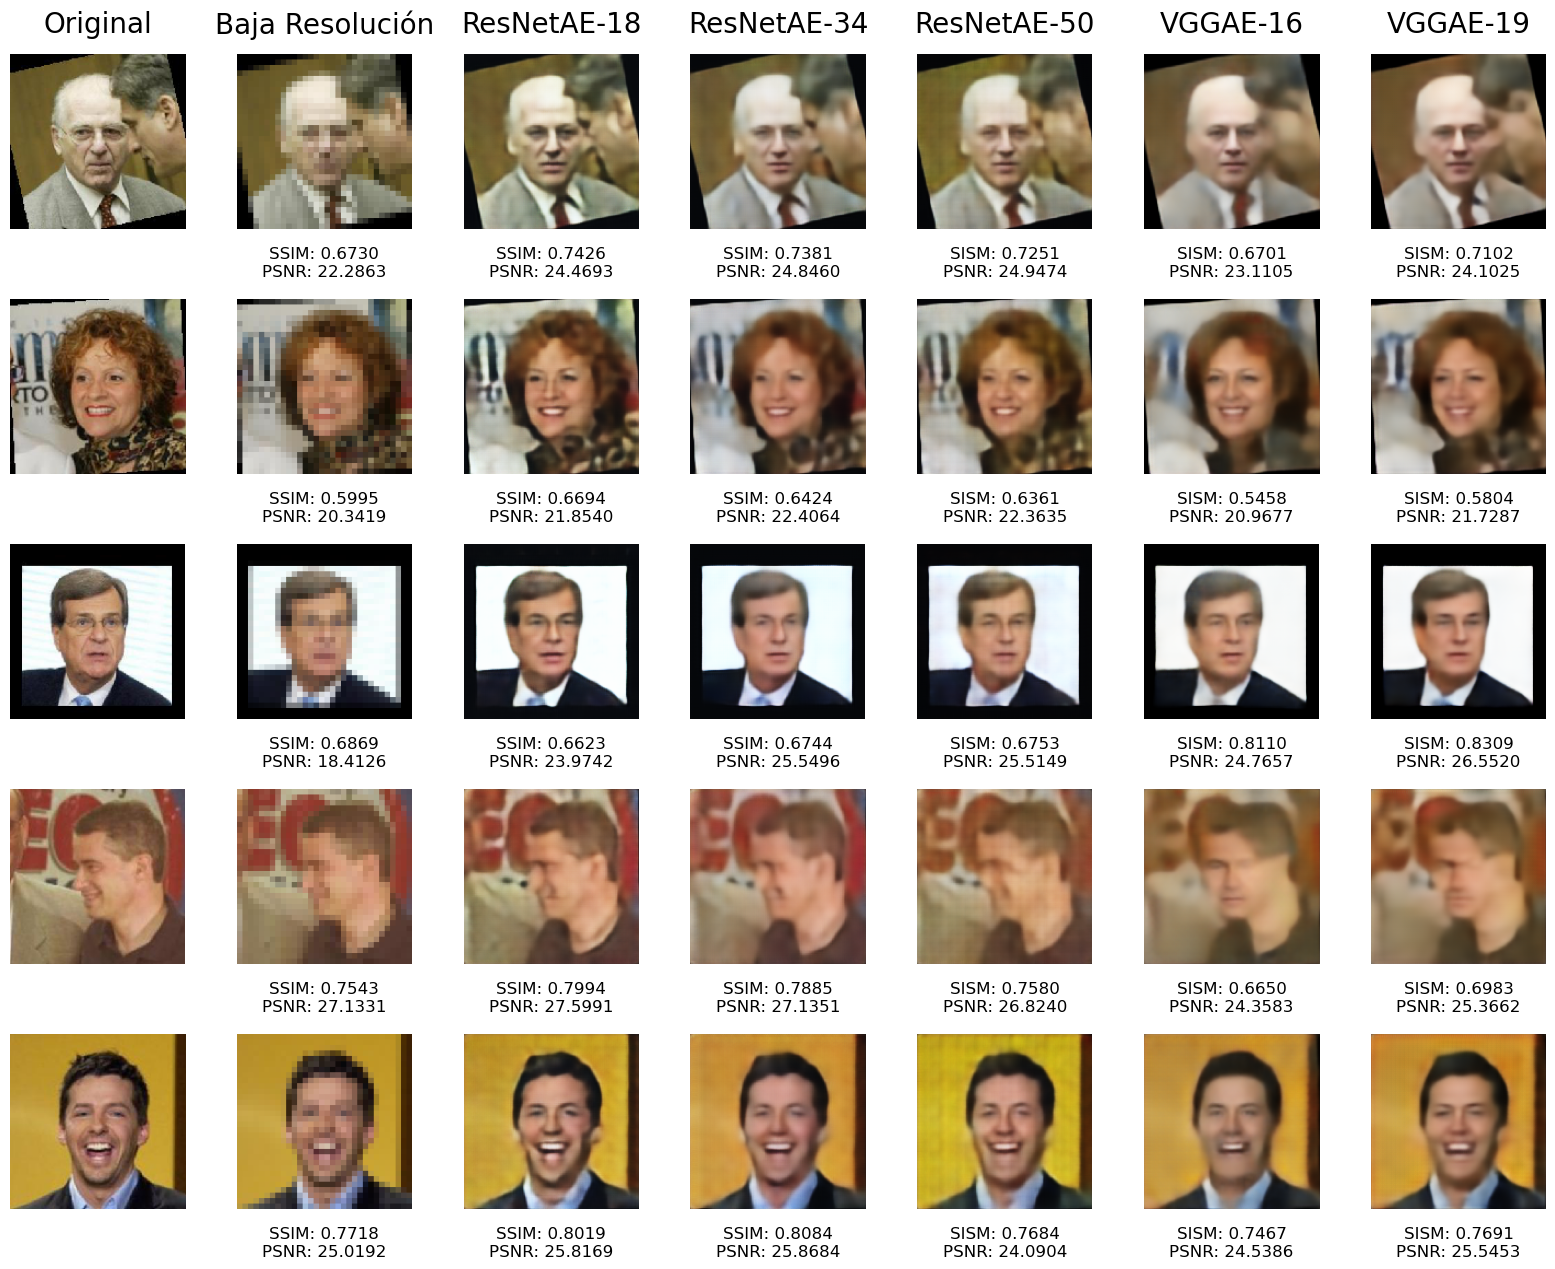

In [20]:
display([762,2235,359,2629,2112], "es")